mapping horizons for eigsep

In [2]:
import numpy as np
import matplotlib.pylab as plt
from eigsep_terrain.marjum_dem import MarjumDEM as DEM
import eigsep_terrain as et
import eigsep_terrain.utils as etu
import tqdm
import healpy
from image_class import Image

In [3]:
CACHE_FILE = 'marjum_dem.npz'
dem = DEM(cache_file=CACHE_FILE)

In [4]:
# load image data
img0 = Image(pathname='/Users/komalkaur/Desktop/eigsep_stuff/horizon_mapping/crosshair-imgs/IMG_0765.PNG', 
            label='img0', lat=39.247880, lon=-113.402623, alt=1698.0, heading=88,
            angle_up=84.6, ver_weight=1/4, hor_weight=1/16, dis_weight=23*47)

img1 = Image(pathname='/Users/komalkaur/Desktop/eigsep_stuff/horizon_mapping/crosshair-imgs/IMG_0771.PNG', 
            label='img1', lat=39.247441, lon=-113.402693, alt=1659.0, heading=358,
            angle_up=49.0, ver_weight=1/24, hor_weight=1/8, dis_weight=13*14)

img2 = Image(pathname='/Users/komalkaur/Desktop/eigsep_stuff/horizon_mapping/crosshair-imgs/IMG_0773.PNG', 
            label='img2', lat=39.247484, lon=-113.402730, alt=1695.0, heading=352,
            angle_up=50, ver_weight=1/7, hor_weight=1/22, dis_weight=12*16)

img3 = Image(pathname='/Users/komalkaur/Desktop/eigsep_stuff/horizon_mapping/crosshair-imgs/IMG_0785.PNG', 
            label='img3', lat=39.247797, lon=-113.402905, alt=1713.0, heading=166,
            angle_up=84.8, ver_weight=1/32, hor_weight=1/6, dis_weight=11*10)

img4 = Image(pathname='/Users/komalkaur/Desktop/eigsep_stuff/horizon_mapping/crosshair-imgs/IMG_0787.PNG', 
            label='img4', lat=39.247566, lon=-113.402991, alt=1746.0, heading=150,
            angle_up=85.0, ver_weight=1/11, hor_weight=1/57, dis_weight=9*13)

img5 = Image(pathname='/Users/komalkaur/Desktop/eigsep_stuff/horizon_mapping/crosshair-imgs/IMG_0820.PNG', 
            label='img5', lat=39.248385, lon=-113.401491, alt=1761.0, heading=236,
            angle_up=13.0, ver_weight=1/7, hor_weight=1/5, dis_weight=4*6)

img6 = Image(pathname='/Users/komalkaur/Desktop/eigsep_stuff/horizon_mapping/crosshair-imgs/IMG_0886.PNG', 
            label='img6', lat=39.248631, lon=-113.404227, alt=1834.0, heading=133,
            angle_up=-17.3, ver_weight=1/15, hor_weight=1/9, dis_weight=9*10)

img7 = Image(pathname='/Users/komalkaur/Desktop/eigsep_stuff/horizon_mapping/crosshair-imgs/IMG_0825.PNG', 
            label='img7', lat=39.248400, lon=-113.401572, alt=1759.0, heading=240,
            angle_up=17.4, ver_weight=1/18, hor_weight=1/8, dis_weight=6*7)


In [5]:
# enus for each photo TODO: is up the same as alt??
enu0 = dem.latlon_to_enu(img0.lat, img0.lon, img0.alt)
enu1 = dem.latlon_to_enu(img1.lat, img1.lon, img1.alt)
enu2 = dem.latlon_to_enu(img2.lat, img2.lon, img2.alt)
enu3 = dem.latlon_to_enu(img3.lat, img3.lon, img3.alt)
enu4 = dem.latlon_to_enu(img4.lat, img4.lon, img4.alt)
enu5 = dem.latlon_to_enu(img5.lat, img5.lon, img5.alt)
enu6 = dem.latlon_to_enu(img6.lat, img6.lon, img6.alt)
enu7 = dem.latlon_to_enu(img7.lat, img7.lon, img7.alt)
enus = [enu0, enu1, enu2, enu3, enu4, enu5, enu6, enu7]
imgs = [img0, img1, img2, img3, img4, img5, img6, img7]


In [6]:
# DEMs from each photo
# dem0 = dem.interp_alt(enu0[0], enu0[1])
# dem1 = dem.interp_alt(enu1[0], enu1[1])
# dem2 = dem.interp_alt(enu2[0], enu2[1])
# dem3 = dem.interp_alt(enu3[0], enu3[1])
# dem4 = dem.interp_alt(enu4[0], enu4[1])
# dem5 = dem.interp_alt(enu5[0], enu5[1])
# dem6 = dem.interp_alt(enu6[0], enu6[1])
# dem7 = dem.interp_alt(enu7[0], enu7[1])


In [13]:
# ploting functions

def color_str2tup(s):
    r, g, b = s[0:2], s[2:4], s[4:6]
    return tuple(map(lambda x: int(x, base=16) / 255, (r, g, b)))

def plot_img(ax, data, res=dem.res, xlabel=True, ylabel=True,
             colorbar=False, cmap='terrain', erng=None, nrng=None, **kw):
    '''Plot maps with standard format.'''
    if nrng is None:
        nrng = (0, data.shape[0] * res)
    if erng is None:
        erng = (0, data.shape[1] * res)
    extent = erng + nrng
    im = ax.imshow(data, extent=extent, cmap=cmap, origin='lower', interpolation='nearest', **kw)
    if colorbar:
        plt.colorbar(im)
    if xlabel:
        ax.set_xlabel('East [m]')
    if ylabel:
        ax.set_ylabel('North [m]')

def hrzn_angle_plotter(enu, idx):
    '''plot horizon angles for a given enu'''
    # calculate horizon angles
    horizon_angles = {}
    horizon_pnts = {}
    for k in ('1', '2'):
        pnt = enu
        delta_h = 0 #m
        _pnt = pnt + np.array([0, 0, delta_h])
        horizon_angles[k+' '+str(delta_h)], horizon_pnts[k+' '+str(delta_h)] = dem.calc_horizon(*_pnt, n_az=512)

    # plot horizon angles
    fig, ax = plt.subplots()
    plot_img(ax, dem.data, dem.res)
    for k in horizon_angles.keys():
        # color = ax._get_lines.get_next_color()
        plt.plot(horizon_pnts[k][1], horizon_pnts[k][0], '.-')
        plt.plot([enu[0]], [enu[1]], '+')
    _ = plt.title(f'Horizon Points for img{idx}')


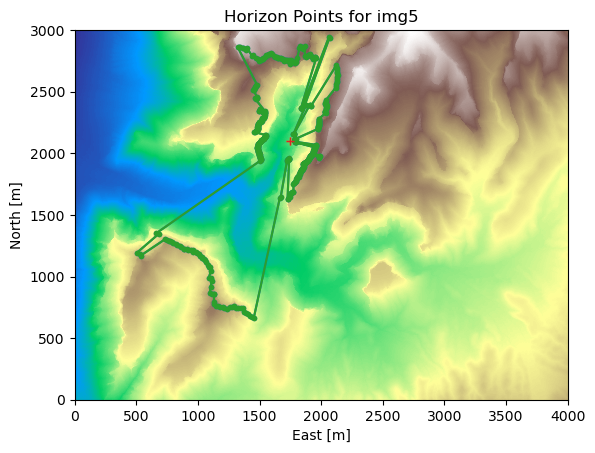

In [14]:
# # horizon angle plots
# hrzn_angle_plotter(enu0, 0)
# hrzn_angle_plotter(enu1, 1)
# hrzn_angle_plotter(enu2, 2)
# hrzn_angle_plotter(enu3, 3)
# hrzn_angle_plotter(enu4, 4)
hrzn_angle_plotter(enu5, 5)
# hrzn_angle_plotter(enu6, 6)
# hrzn_angle_plotter(enu7, 7)

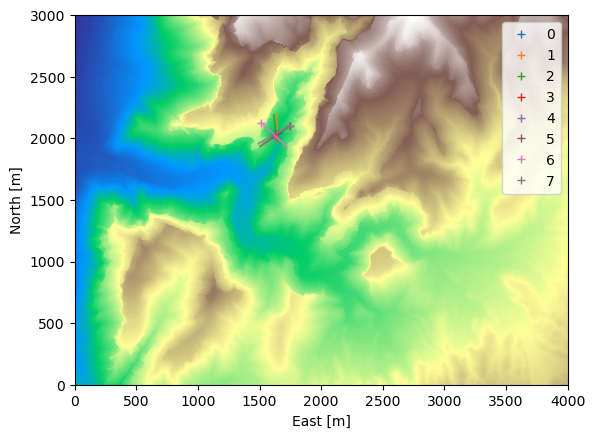

In [11]:
fig, ax = plt.subplots()
plot_img(ax, dem.data, dem.res)
for enu_idx in range(len(enus)):
    az = np.deg2rad(imgs[enu_idx].heading)
    pitch = np.deg2rad(imgs[enu_idx].angle_up)
    r = np.array([0, 300])
    easts = r * np.sin(az) * np.cos(pitch) + enus[enu_idx][0]
    norths = r * np.cos(az) * np.cos(pitch) + enus[enu_idx][1]

    line, = ax.plot([enus[enu_idx][0]], [enus[enu_idx][1]], '+', label=enu_idx)
    ax.plot(easts, norths, color=line.get_color(), alpha=0.7)


# ax.set_xlim(1500-250, 2500-250)
# ax.set_ylim(1500, 2500)
plt.legend(loc="best")
